In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [2]:
m, b = 4.66402766, 2.22976949
m_err, b_err = 0.00618106, 1.384337

## 2 Lead N Paraffin

In [3]:
titles, fnames = zip(*[
    ('No Paraffin', './data/pu-unplugged-lead2-1.csv'), 
    ('8 Paraffin Blocks', './data/pu-unplugged-lead2paraffin8.csv'), 
    ('15 Paraffin Blocks', './data/pu-unplugged-lead2paraffin15.csv'), 
])

/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48034/4151691513.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(m * channels + b, np.log(rate), color='k', s=2, alpha=0.25)


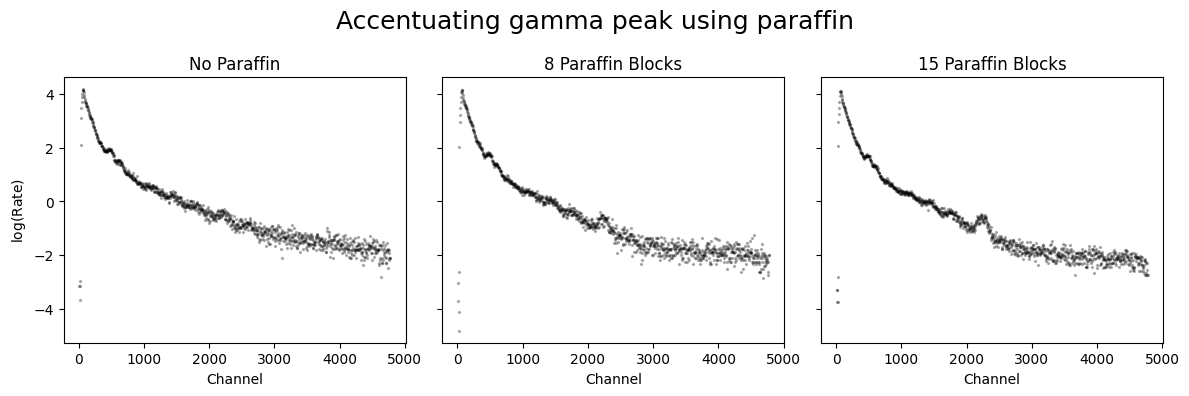

In [4]:
fig, axs = plt.subplots(1, len(fnames), figsize=(4 * len(fnames), 4), sharey=True)

for ax, title, fname in zip(axs, titles, fnames):
    
    time, channels, counts = parse_usx_csv(fname)
    rate = counts / time
    rate_err = np.sqrt((counts / time**2) + (counts**2 * 0.1**2 / time**4))
    
    ax.scatter(m * channels + b, np.log(rate), color='k', s=2, alpha=0.25)
    ax.set_title(title)
    ax.set_xlabel('Channel')

axs[0].set_ylabel(r'$\log (\text{Rate})$')
fig.suptitle('Accentuating gamma peak using paraffin', fontsize=18)
plt.tight_layout()

fig.savefig('./figures/paraffin_accentuation.pdf')

/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48034/1484386982.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(m * channels + b, np.log(rate), cmap=(i * 8), s=2, alpha=0.25)
/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48034/1484386982.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(m * channels + b, np.log(rate), cmap=(i * 8), s=2, alpha=0.25)


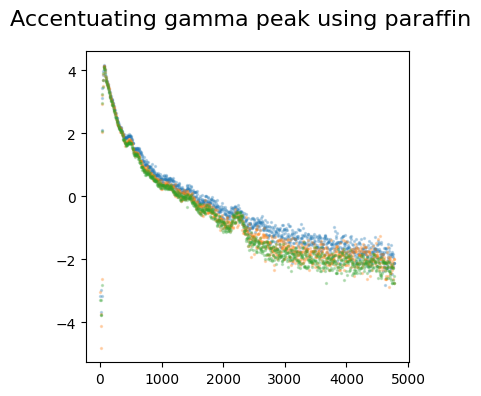

In [5]:
fig, ax = plt.subplots(figsize=(4, 4), sharey=True)

for i, (title, fname) in enumerate(zip(titles, fnames)):
    
    time, channels, counts = parse_usx_csv(fname)
    rate = counts / time
    rate_err = np.sqrt((counts / time**2) + (counts**2 * 0.1**2 / time**4))
    
    ax.scatter(m * channels + b, np.log(rate), cmap=(i * 8), s=2, alpha=0.25)

axs[0].set_ylabel(r'$\log (\text{Rate})$')
fig.suptitle('Accentuating gamma peak using paraffin', fontsize=16)
plt.tight_layout()

Something has gone wrong: Initial guess is outside of provided bounds


/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48034/1184403913.py:12: RuntimeWarning: divide by zero encountered in reciprocal
  ( (spectrum/time**2) + (spectrum**2) * (0.1**2)/(time**4) ) ** -1
/var/folders/lz/3l45kw_56ln6k0x68wfrb0th0000gn/T/ipykernel_48034/1184403913.py:19: RuntimeWarning: invalid value encountered in multiply
  (spectrum * spectrum_weight).sum(axis=1) / spectrum_weight.sum(axis=1)


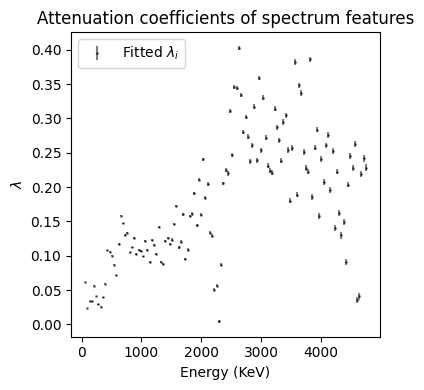

In [6]:
times, channels, spectra = zip(*[parse_usx_csv(fname) for fname in fnames])

# Bin

binned_channel = (m * channels[0] + b).reshape(128, 8).mean(axis=1)
binned_spectra = [spectrum.reshape(128, 8) for spectrum in spectra]

# Convert counts to rates

binned_spectra = [spectrum/time for spectrum, time in zip(binned_spectra, times)]
binned_spectra_weights = [
    ( (spectrum/time**2) + (spectrum**2) * (0.1**2)/(time**4) ) ** -1
    for spectrum, time in zip(binned_spectra, times)
]

# Weighted mean and uncertainty

digitized_spectra = [
    (spectrum * spectrum_weight).sum(axis=1) / spectrum_weight.sum(axis=1)
    for spectrum, spectrum_weight in zip(binned_spectra, binned_spectra_weights)
]
digitized_spectra_err = [
    np.sqrt(spectrum_weight.sum(axis=1)) ** -1
    for spectrum_weight in binned_spectra_weights
]

digitized_spectra = np.stack(digitized_spectra)
digitized_spectra_err = np.stack(digitized_spectra_err)

lambdas, lambdas_err = [], []
for i in range(digitized_spectra.shape[1]):

    params_i = [float(digitized_spectra[0, i]), 0]
    params, params_err, chisq, dof = data_fit(
        params_i, exponential, 
        range(digitized_spectra.shape[0]), digitized_spectra[:, i], digitized_spectra_err[:, i]
    )

    lambdas.append(params[1])
    lambdas_err.append(params_err[1])

fig, ax = plt.subplots(1, figsize=(4, 4), sharey=True)

ax.errorbar(
    x=binned_channel[1:], y=lambdas[1:], yerr=lambdas_err[1:], 
    fmt='k.', markersize=2, alpha=0.5, 
    label='Fitted $\lambda_i$'
)
ax.set_xlabel('Energy (KeV)')
ax.set_ylabel('$\lambda$')
ax.set_title('Attenuation coefficients of spectrum features')
ax.legend()

plt.tight_layout()